### Notes sur l'article de QAOA: 

QAOA vise à trouver l'énergie fondamentale soit la plus petite énergie par une fonction d'onde paramétrée, on cherche la valeur du paramètre qui va minimiser la fonction. 
Pour un état $|\psi\rangle$ donné, une énergie fondamentale $E_0$, on aurait: $$E_0 \leq \frac{\langle\psi | H |\psi \rangle}{\langle\psi | \psi \rangle}$$

On prend une entrée et on génère un ket paramétré en appliquant un opérateur paramétré, avec ce ket paramétré, on peut calculer la moyenne de l'hamiltonien à multiple reprises et trouver le paramètre qui va minimiser cette valeur moyenne. 
$$\lambda = min_\theta \langle\psi_0 |U^\dag(\theta) H U(\theta)|\psi_0\rangle$$
$$\lambda_{min} = E_0 \approx \langle\psi(\theta^*) | H |\psi(\theta^*)\rangle$$


#### Fonction objective et $m$ contraintes: 

On veut optimiser une fonction coût: $C(x)$ où $x$ fait partie du domaine $d$. En quantique, on peut représenter le tout comme un opérateur $H_C$ agissant sur un ket 
$ |z\rangle$, où $z$ est une chaîne de bits appartenant à l'ensemble $\{ 0,1\}^{\otimes n }$. 

$$H_C|z\rangle = \sum_{k=1}^{m'} C_k|z\rangle = C|z\rangle $$

Ici, $C_k$ est associée à une contrainte, que, lorsque respectée, donne la valeur de 1 à C, 0 sinon. 
On définit une fonction coût pouvant être mappé à un Hamiltonien. Il faut considérer les contraintes du point de départ, de fin ainsi que les points intermédiaires de manière à avoir un chemin plus court. En ajoutant une valeur plus ou moins importante au M, on augmente la valeur de la fonction qu'on cherche à maximiser. On veut que C soit le plus grand possible de manière à garder le chemin avec les poids les plus grands (plus grande probabilité de diffusion). Ensuite, si une contrainte n'est pas respectée, M sera non nul ce qui viendra diminuer la valeur de F qu'on cherche à maximiser (M > 0).  

Il s'agit de l'Hamiltonien (temporaire) donné par : $$F = C - M (\sum_{j=1}^n x_{sj} -1 )²  - M (\sum_{i=1}^n x_{id} -1 )²- M \sum_{k \in V, k \neq s, d}^n (\sum_{i=1}^n x_{ik} - \sum_{j=1}^n x_{kj} )²$$


On sait que C est le coût du plus court chemin, $$C = \sum_{i,j} w_{ij} x_{ij}$$

Dans notre cas, nos poids sont donnés par : 

$$w_{ij} = w_{ji} = P_{mat}(i) \cdot P_{mat}(j) \cdot [P_{Diff}(i, r_{ij}) + P_{Diff}(j, r_{ji})]$$

Dans reconst.py, on peut voir  : 

```
w = sf[start_x, start_y, dir_id] + sf[conn_x, conn_y, dir_id] 
```

#### Librairies : 

In [114]:
import numpy as np 
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw
from qiskit.quantum_info import SparsePauliOp
import numpy as np

from scipy.optimize import minimize

from qiskit.circuit.library import QAOAAnsatz
# from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator, Sampler
from qiskit.visualization import plot_distribution

import matplotlib.pyplot as plt
import networkx as nx


#### Graphe pour tester les noeuds connectés à deux autres en triangle: 
#### Graph to test connected nodes in triangular fashion :

In [115]:
# # We can try a test adjacency matrix (symetric with a zero element on diagonal) where each node is connected to two others: 
# nodes = 3 
# triangle_mat = np.array([[0.0, 1.0 ,1.0],[ 1.0, 0.0, 0.0],[ 1.0 ,0.0, 0.0]])

# # normalise to 0.5: 
# random_num_max_05 = np.random.default_rng().random()/2
# triangle_mat *= random_num_max_05
# triangle_mat[0,2] = 0.398374 
# triangle_mat[2,0] = triangle_mat[0,2]
# triangle_mat[1,2] = 0.297635
# triangle_mat[2,1] = triangle_mat[1,2]
# print(f'Adjacency matrix: \n {triangle_mat}') 

# # read matrix from left to right, top to bottom : 
# one_D_array_connections = triangle_mat.flatten()
# one_D_array_connections = list(one_D_array_connections)
# print(f'\n 1D array of adjacency matrix: \n {one_D_array_connections}') 
# # With the adjacency matrix, we can build a graph: 
# graph = rx.PyGraph()
# nodes_list = graph.add_nodes_from((range(nodes)))
# graph.add_edges_from([(0, 1, triangle_mat[0,1]), (1, 2, triangle_mat[1,2]), (2, 0, triangle_mat[2,0])])

# draw(graph, with_labels=True, edge_labels=str) # type: ignore

#### Graphe pour tester l'algorithme de QAOA: 
#### Graph to test QAOA algorithm: 

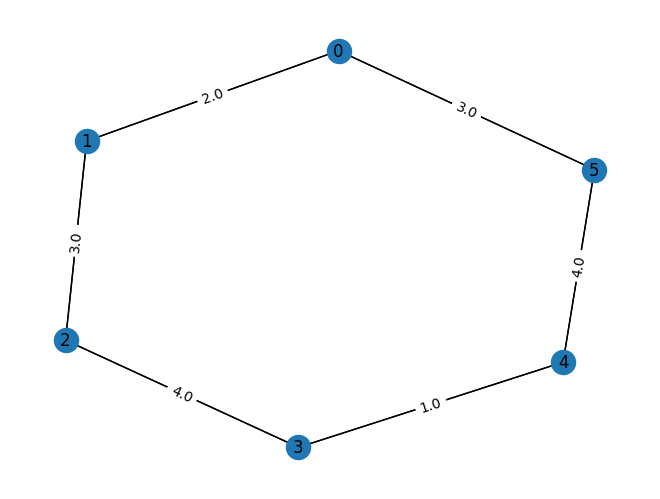

In [116]:
# # Let's create a bigger graph with more intersections : 
# # Version avec croisement :
# mat_adj =  10*np.array([[0.0, 0.2, 0.0, 0.0, 0.0, 0.3],
#                         [0.2, 0.0, 0.3, 0.0, 0.0, 0.0],
#                         [0.0, 0.3, 0.0, 0.4, 0.1, 0.3],
#                         [0.0, 0.0, 0.4, 0.0, 0.1, 0.0],
#                         [0.0, 0.0, 0.1, 0.1, 0.0, 0.4],
#                         [0.3, 0.0, 0.3, 0.0, 0.4, 0.0]])

# Version sans croisement : 
mat_adj =  10*np.array([[0.0, 0.2, 0.0, 0.0, 0.0, 0.3],
                        [0.2, 0.0, 0.3, 0.0, 0.0, 0.0],
                        [0.0, 0.3, 0.0, 0.4, 0.0, 0.0],
                        [0.0, 0.0, 0.4, 0.0, 0.1, 0.0],
                        [0.0, 0.0, 0.0, 0.1, 0.0, 0.4],
                        [0.3, 0.0, 0.0, 0.0, 0.4, 0.0]])

# With the adjacency matrix, we can build a graph : 
graph_cross = rx.PyGraph()
num_nodes_cross_graph = 6 
nodes_list = graph_cross.add_nodes_from((range(num_nodes_cross_graph)))

# Add edges : 
edges = []
for i in range(num_nodes_cross_graph):
    for j in range(num_nodes_cross_graph):
        if mat_adj[i, j] != 0:
            edges.append((i, j, mat_adj[i, j]))
            
# print(edges)
graph_cross.add_edges_from(edges)
draw(graph_cross, with_labels=True, edge_labels=str) # type: ignore

#### Je définis mon point de départ comme étant le noeud 0 et mon point final étant le noeud 5. 

Automatisé: 

In [117]:
start = 0
finish = 5 

# We know that the total weight is the sum of the elements in the upper or lower triangle of the adjacency matrix: 
all_weights_sum  = sum(np.tril(mat_adj).flatten())

# Defining possible connexions from starting node and its neighbours: 
start_node_adj_mat = mat_adj[start]
possible_starts = []
for node,value in enumerate(start_node_adj_mat):
    if value>0:
        possible_starts.append(node)
print(f'Possible starts from node {start} to node(s) : {possible_starts}')

nodes_num = mat_adj.shape[0]
initial_pauli_op = []
for i in range(nodes_num):
    initial_pauli_op.append("I")
str_initial_pauli_op = " ".join(initial_pauli_op)

print(np.tril(mat_adj))
print(np.tril(mat_adj).flatten())


Possible starts from node 0 to node(s) : [1, 5]
[[0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0.]
 [0. 0. 4. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [3. 0. 0. 0. 4. 0.]]
[0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 3. 0. 0. 0. 4. 0.]


#### Manuel:

Poit départ = 0 

Point final = 5 

q0 = 0-1    : valeur = 2

q1 = 0-5    : valeur = 3

q2 = 1-2    : valeur = 3

q3 = 2-3    : valeur = 4

q4 = 2-4    : valeur = 1

q5 = 2-5    : valeur = 3

q6 = 3-4    : valeur = 1

q7 = 4-5    : valeur = 4

$$H_C = 2q_0 + 3q_1 + 3q_2 + 4q_3 + 1q_4 + 3q_5 + 1q_6 + 4q_7$$
$$H_C = 2(\frac{I_0+Z_0}{2}) + 3(\frac{I_1+Z_1}{2})+ 3(\frac{I_2+Z_2}{2}) + 4(\frac{I_3+Z_3}{2}) + 1(\frac{I_4+Z_4}{2})+ 3(\frac{I_5+Z_5}{2}) + 1(\frac{I_6+Z_6}{2})+ 4(\frac{I_7+Z_7}{2})$$
$$H_C = \frac{21}{2} I^{\otimes 8} + 1Z_0 + 1.5 Z_1 + 1.5 Z_2 + 2 Z_3 + 0.5 Z_4 + 1.5 Z_5 + 0.5 Z_6 + 2 Z_7$$

In [118]:
# # Basic cost Hamiltonian depending on edges' weights.
# # Version avec croisement 
# h_c = SparsePauliOp.from_list([("IIIIIIII",all_weights_sum/2),
#                                ("IIIIIIIZ", -mat_adj[0,1] /2),
#                                ("IIIIIIZI", -mat_adj[0,5] /2),
#                                ("IIIIIZII", -mat_adj[1,2] /2),
#                                ("IIIIZIII", -mat_adj[2,3] /2),
#                                ("IIIZIIII", -mat_adj[2,4] /2),
#                                ("IIZIIIII", -mat_adj[2,5] /2),
#                                ("IZIIIIII", -mat_adj[3,4] /2),
#                                ("ZIIIIIII", -mat_adj[4,5] /2)])

# Version sans croisement : 
h_c = SparsePauliOp.from_list([("IIIIII",all_weights_sum/2),
                               ("IIIIIZ", -mat_adj[0,1] /2),
                               ("IIIIZI", -mat_adj[0,5] /2),
                               ("IIIZII", -mat_adj[1,2] /2),
                               ("IIZIII", -mat_adj[2,3] /2),
                            #    ("IIIZIIII", -mat_adj[2,4] /2),
                            #    ("IIZIIIII", -mat_adj[2,5] /2),
                               ("IZIIII", -mat_adj[3,4] /2),
                               ("ZIIIII", -mat_adj[4,5] /2)])

$$H_S  = q_0 + q_1 $$
$$H_S = \frac{I_0+Z_0}{2}+ \frac{I_1+Z_1}{2} $$

In [119]:
# # condition to make sure we only "leave" once from the starting node.

# # Version avec croisement 
# h_s = SparsePauliOp.from_list([("IIIIIIZI", -0.5),
#                                ("IIIIIIIZ", -0.5)])
# Version sans croisement 
h_s = SparsePauliOp.from_list([("IIIIZI", -0.5),
                               ("IIIIIZ", -0.5)])

$$H_F  = q_1 + q_5 + q_7 $$
$$H_F = \frac{I_1+Z_1}{2}+ \frac{I_5+Z_5}{2}+\frac{I_7+Z_7}{2}  $$

In [120]:
# # condition to make sure we only "arrive" once at the finishing node.
# # Version avec croisement :
# h_f = SparsePauliOp.from_list([("IIIIIIZI", -0.5),
#                                ("IIZIIIII", -0.5),
#                                ("ZIIIIIII", -0.5)])

# Version sans croisement :
h_f = SparsePauliOp.from_list([("IIIIZI", -0.5),
                               ("ZIIIII", -0.5)])


$$H_{int} = ?? $$

In [121]:
# # Version avec croisement 
# h_1 = SparsePauliOp.from_list([("IIIIIZII", -0.5),
#                                ("IIIIIIIZ", +0.5)])

# h_2 = SparsePauliOp.from_list([("IIIIZIII", -0.5),
#                                ("IIIZIIII", -0.5),
#                                ("IIZIIIII", -0.5),
#                                ("IIIIIZII", +0.5)])

# h_3 = SparsePauliOp.from_list([("IZIIIIII", +0.5),
#                                ("IIIIZIII", -0.5)])

# h_4 = SparsePauliOp.from_list([("ZIIIIIII", +0.5),
#                                ("IZIIIIII", -0.5)])
# # Alpha shouldn't be too big to keep the energy spectrum of the hamiltonian usable with QAOA.
# alpha = 18
# # QUBO representation of Hamiltonian (cost function).
# h = -h_c - alpha * ((h_s**2) + (h_f**2) + (h_1**2)  + (h_3**2) + (h_4**2))

# Version sans croisement : 
h_1 = SparsePauliOp.from_list([("IIIZII", -0.5),
                               ("IIIIIZ", +0.5)])

h_2 = SparsePauliOp.from_list([("IIZIII", -0.5),
                               ("IIIZII", +0.5)])

h_3 = SparsePauliOp.from_list([("IZIIII", -0.5),
                               ("IIZIII", +0.5)])

h_4 = SparsePauliOp.from_list([("ZIIIII", -0.5),
                               ("IZIIII", +0.5)])
# Alpha shouldn't be too big to keep the energy spectrum of the hamiltonian usable with QAOA.
alpha = 18
# QUBO representation of Hamiltonian (cost function).
h = h_c + alpha * ((h_s**2) + (h_f**2) + (h_1**2)  + (h_3**2) + (h_4**2))

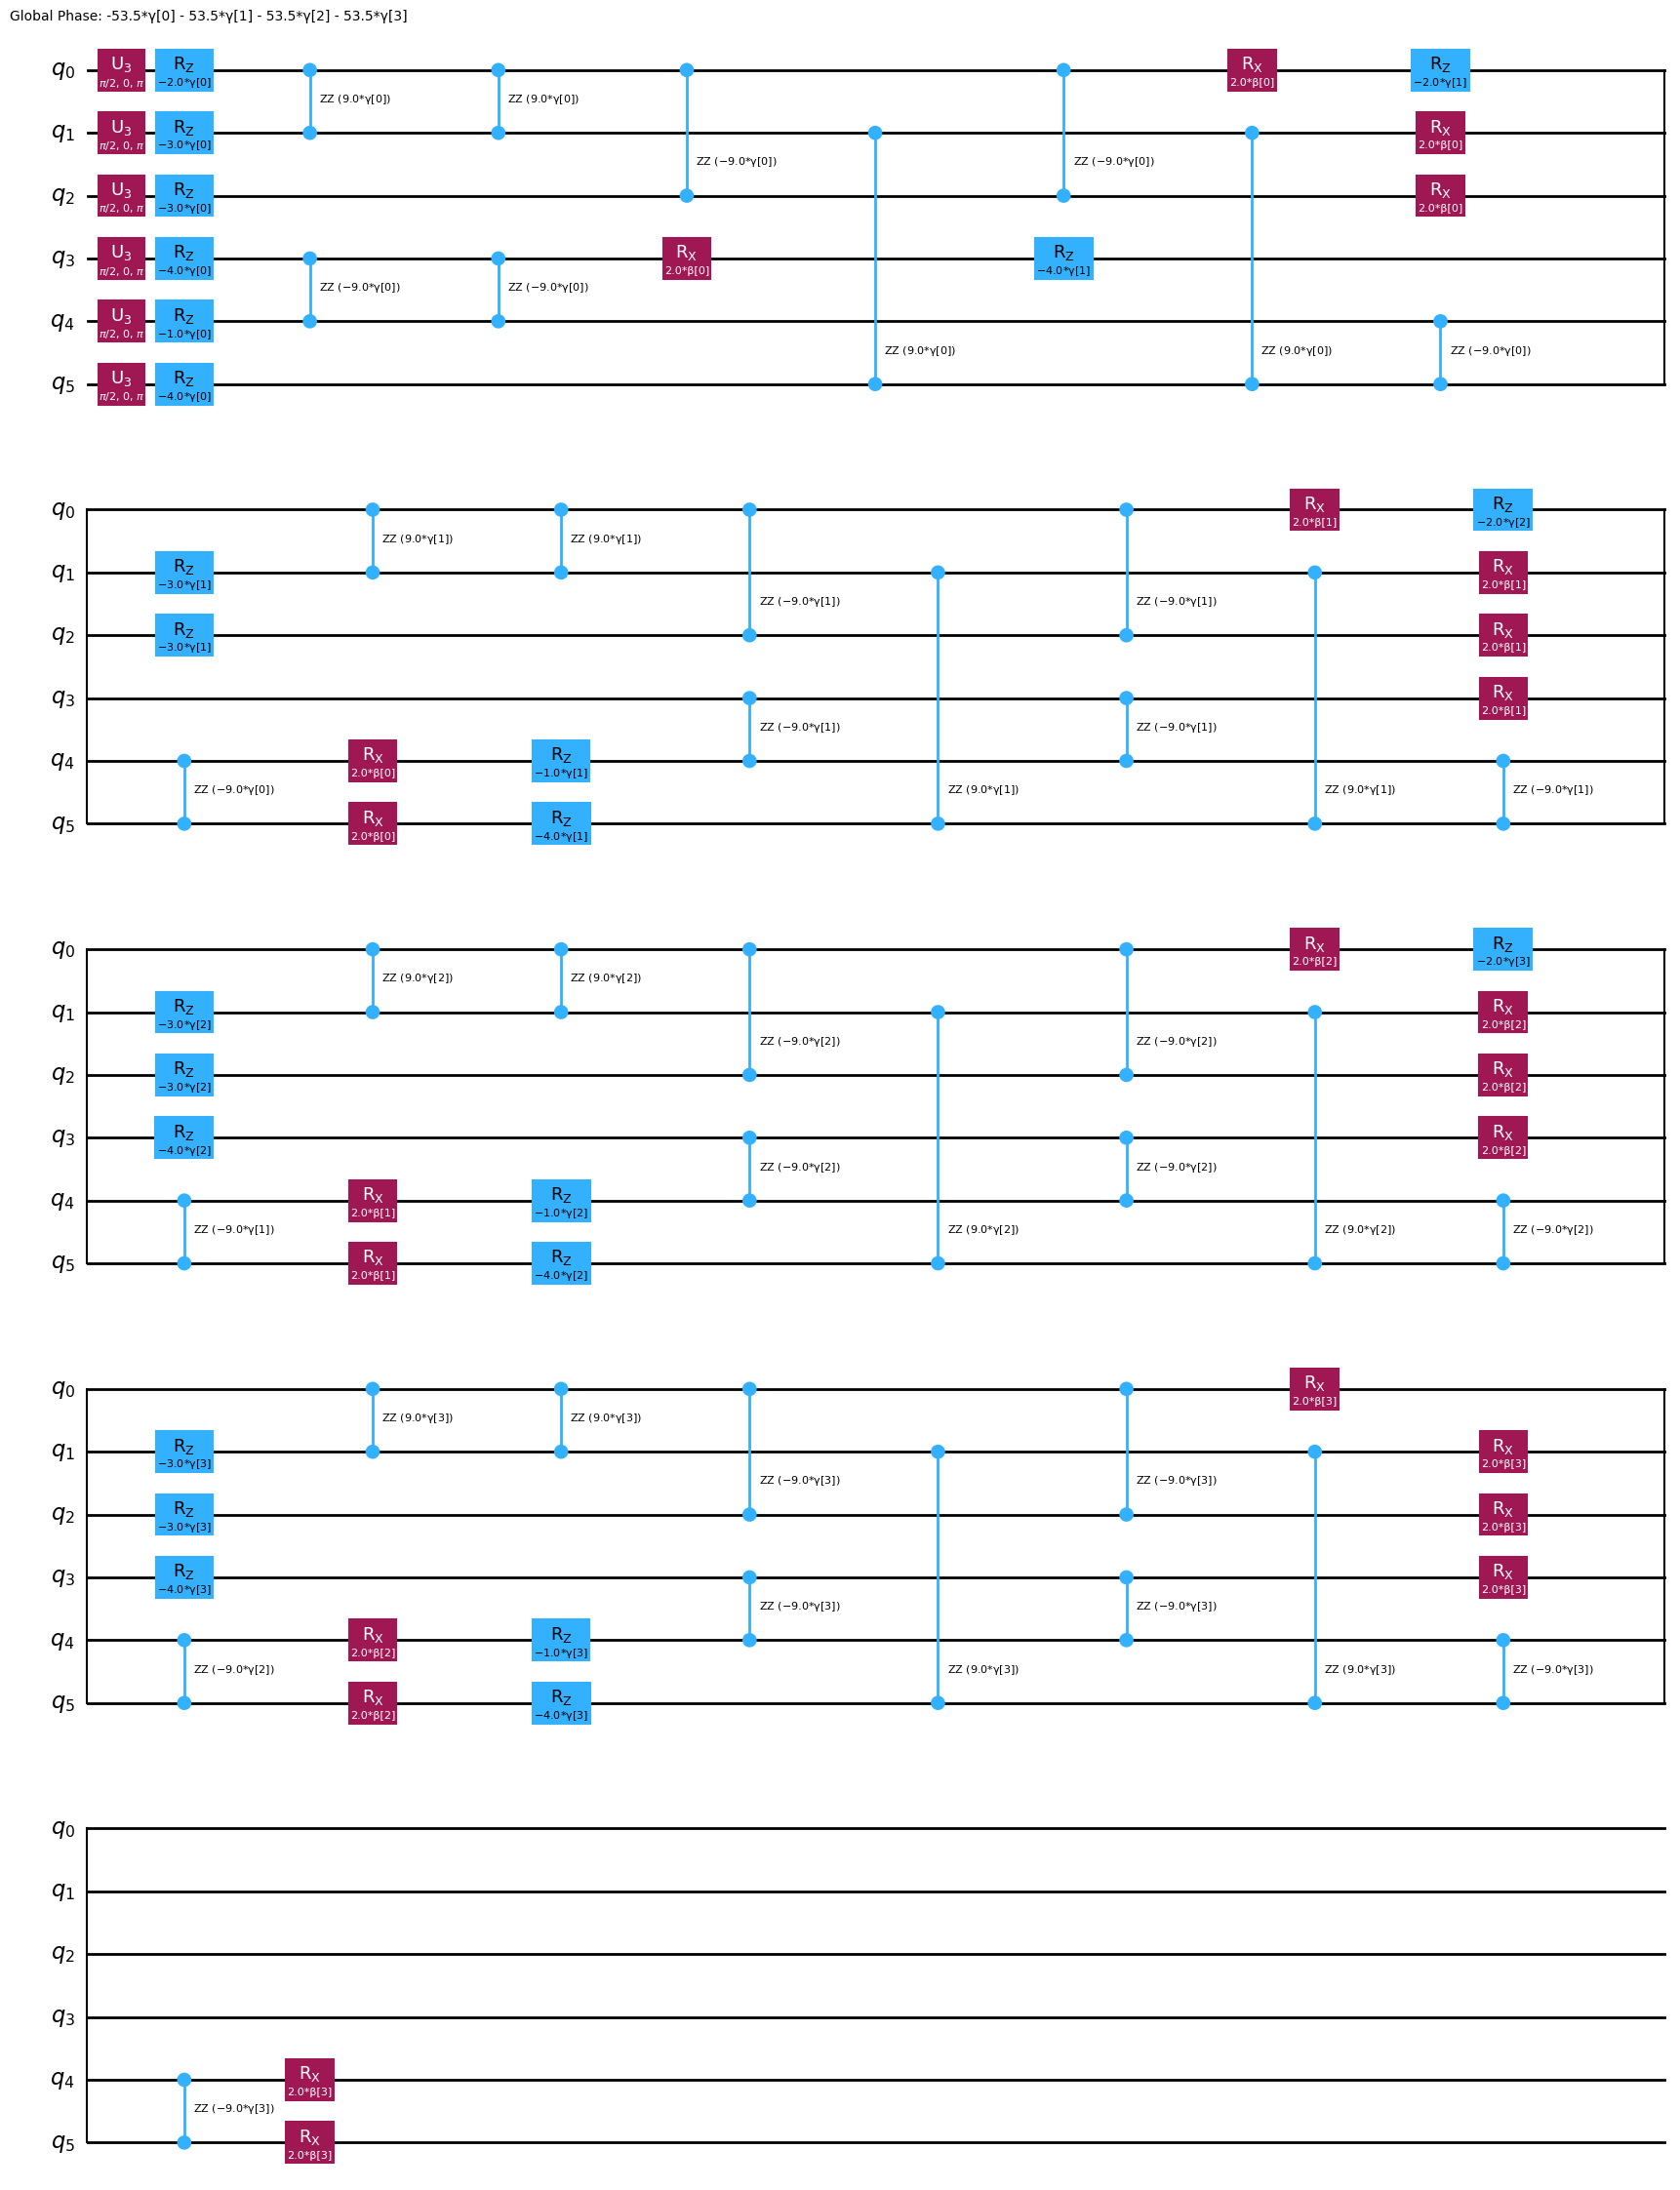

In [122]:
# Create QAOA circuit.
ansatz = QAOAAnsatz(h, reps=4)
ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

In [123]:
# Run on local estimator and sampler. Fix seeds for results reproducibility.
estimator = Estimator(options={"shots": 1000000, "seed" : 42})
sampler = Sampler(options={"shots": 1000000, "seed" :42})

In [124]:
# Cost function for the minimizer.
# Returns the expectation value of circuit with Hamiltonian as an observable.
def cost_func(params, estimator, ansatz, hamiltonian):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [125]:
# Generate starting point. Fixed to zeros for results reproducibility.
# x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
x0 = np.zeros(ansatz.num_parameters)

res = minimize(cost_func, x0, args=(estimator, ansatz, h), method="COBYLA")

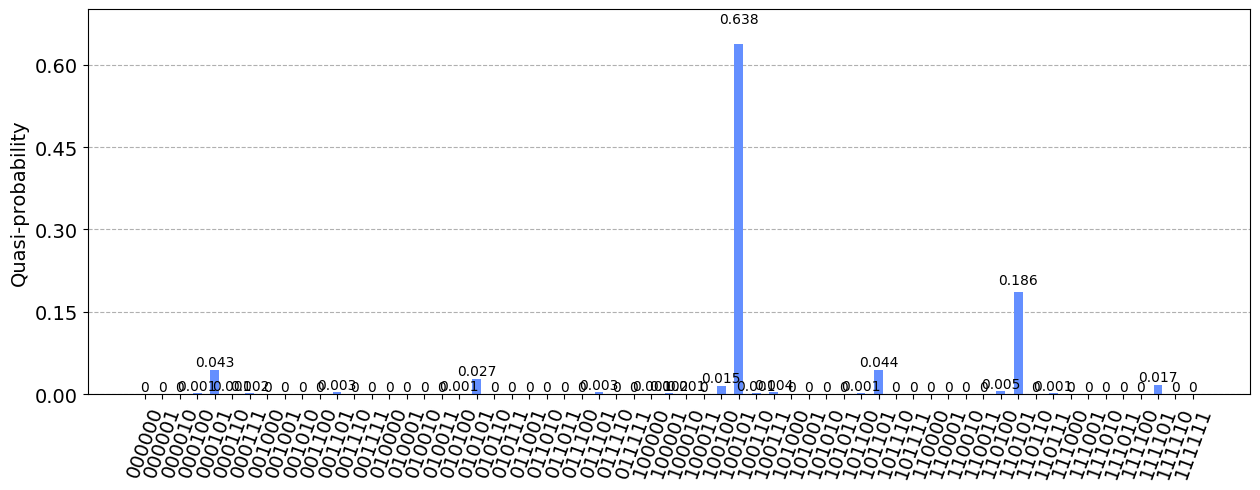

In [126]:
# Get probability distribution associated with optimized parameters.
circ = ansatz.copy()
circ.measure_all()
dist = sampler.run(circ, res.x).result().quasi_dists[0]

plot_distribution(dist.binary_probabilities(), figsize=(15, 5))

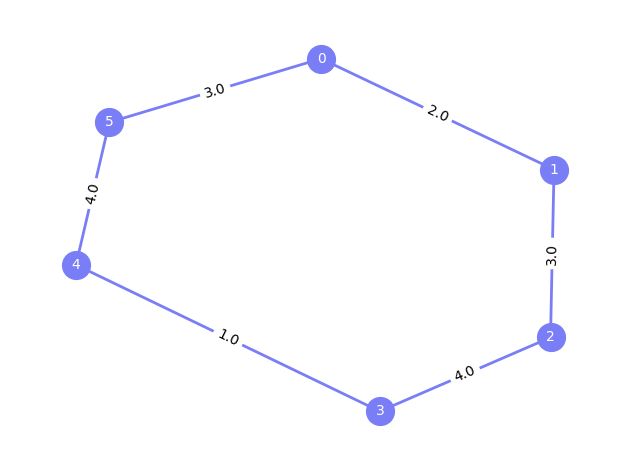

In [129]:
# Plot graph

G = nx.Graph()
G.add_edge(0, 1, weight=2.0)
G.add_edge(1, 2, weight=3.0)
G.add_edge(2, 3, weight=4.0)
# G.add_edge(2, 4, weight=1.0)
# G.add_edge(2, 5, weight=3.0)
G.add_edge(3, 4, weight=1.0)
G.add_edge(4, 5, weight=4.0)
G.add_edge(5, 0, weight=3.0)
pos = nx.spring_layout(G, seed=7)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_nodes(G, pos, node_size=400, node_color="#797EF6")
nx.draw_networkx_edges(G, pos, width=2, edge_color="#797EF6")
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_color="w")
nx.draw_networkx_edge_labels(G, pos, edge_labels)


ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

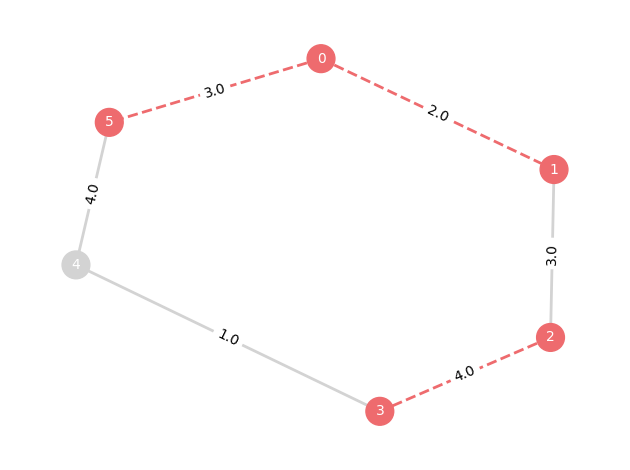

In [130]:
# Display graph
bin_str = list(map(int, max(dist.binary_probabilities(), key=dist.binary_probabilities().get))) # type: ignore
bin_str.reverse()
bin_str.insert(1, bin_str.pop(-1))

pos = nx.spring_layout(G, seed=7)
edge_labels = nx.get_edge_attributes(G, "weight")

e_in  = [(u, v) for i, (u, v, d) in enumerate(G.edges(data=True)) if bin_str[i]]
e_out  = [(u, v) for i, (u, v, d) in enumerate(G.edges(data=True)) if not bin_str[i]]

color_map = np.array(["#D3D3D3"] * G.number_of_nodes())
color_map[list(sum(e_in, ()))] = "#EE6B6E"

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=400)
nx.draw_networkx_edges(G, pos, edgelist=e_in, width=2, alpha=1, edge_color="#EE6B6E", style="dashed")
nx.draw_networkx_edges(G, pos, edgelist=e_out, width=2, edge_color="#D3D3D3")
nx.draw_networkx_edge_labels(G, pos, edge_labels)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_color="w")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()